In [177]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

[autoreload of diffusion_curvature.flattening.mioflow failed: Traceback (most recent call last):
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/envs/cuda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/envs/cuda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/envs/cuda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/envs/cuda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 7 Experiments with Diffusion Ricci Curvature
> Testing the bounds of the method

**Hypothesis**: Stuff will happen

## Machinery

First here's an example usage:

In [178]:
from diffusion_curvature.ricci import DiffusionRicciCurvature
import graphtools

In [179]:
show_doc(DiffusionRicciCurvature)

---

### DiffusionRicciCurvature

>      DiffusionRicciCurvature (laziness_method:Literal['Entropic','Wasserstein'
>                               ,'DirichletEnergy']='Entropic',
>                               allow_self_loops:bool=True, threshold_eps=1e-05)

Initialize self.  See help(type(self)) for accurate signature.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| laziness_method | Literal | Entropic | Method to use for laziness computation |
| allow_self_loops | bool | True | Whether to allow self-loops in graph. |
| threshold_eps | float | 1e-05 |  |

In [180]:
X_torus, ks_torus = torus(200)
G = graphtools.Graph(X_torus, anisotropy=1, knn=15, decay=None).to_pygsp()
A = jnp.array(G.W.todense(), dtype=jnp.float32,)

In [181]:
DRC_plain = DiffusionRicciCurvature()
R = DRC_plain.fit_transform(A, 25)

Using stable entropy


  0%|          | 0/200 [00:00<?, ?it/s]

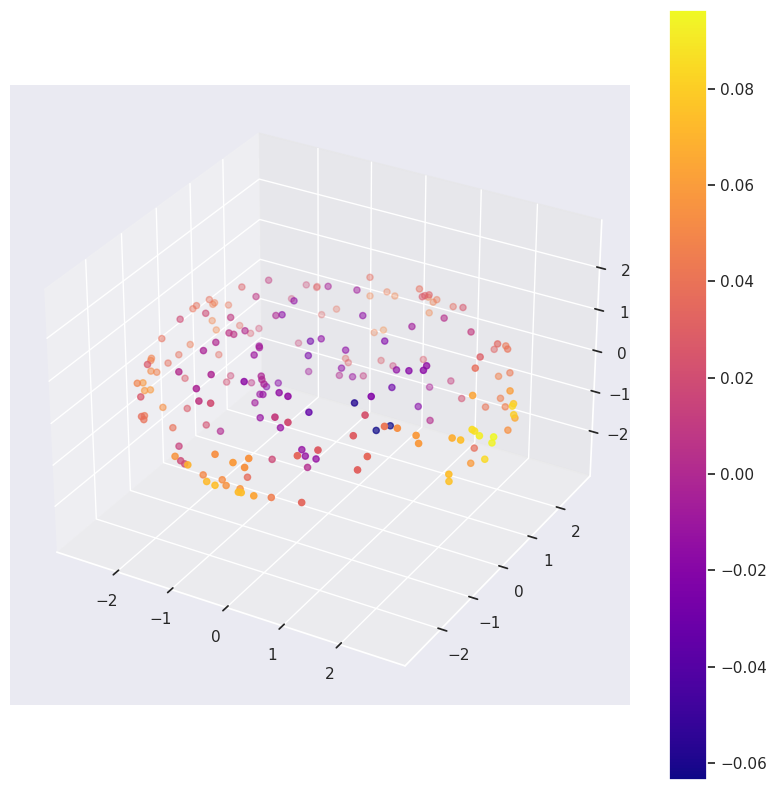

In [182]:
plot_3d(X_torus, DRC_plain.ks, colorbar=True)

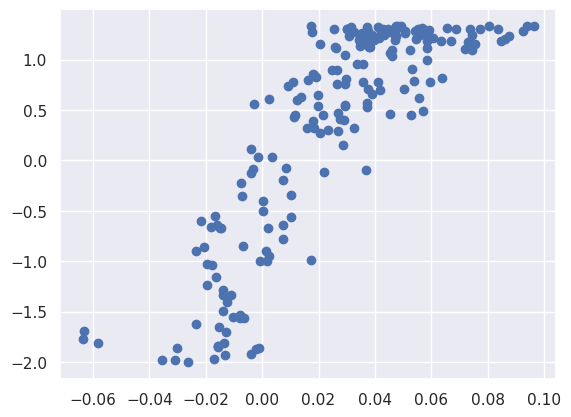

In [183]:
plt.scatter(DRC_plain.ks, ks_torus)

In [184]:
import scipy.stats
scipy.stats.pearsonr(DRC_plain.ks, ks_torus)

PearsonRResult(statistic=0.8446296968049196, pvalue=1.247292797866633e-55)

# Results

## Does DRC work with self loops?

Yes.

In [4]:
X_torus, ks_torus = torus(200)
G = graphtools.Graph(X_torus, anisotropy=1, knn=15, decay=None).to_pygsp()
A = jnp.array(G.W.todense(), dtype=jnp.float32,)

In [5]:
DRC = DiffusionRicciCurvature(
    allow_self_loops = True
)
R = DRC.fit_transform(A, 25)

  0%|          | 0/200 [00:00<?, ?it/s]

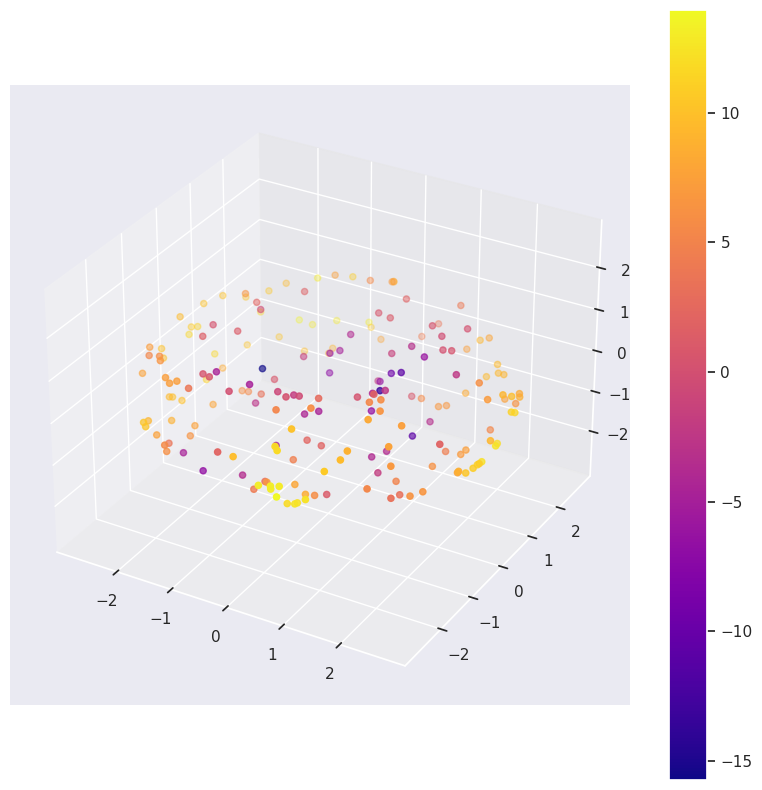

In [6]:
plot_3d(X_torus, DRC.ks, colorbar=True)

## Does DRC assign zero curvature to the plane?

In [3]:
X = plane(200)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
A = jnp.array(G.W.todense(), dtype=jnp.float32,)
DRC = DiffusionRicciCurvature()
R = DRC.fit_transform(A, 25)

Using stable entropy


  0%|          | 0/200 [00:00<?, ?it/s]

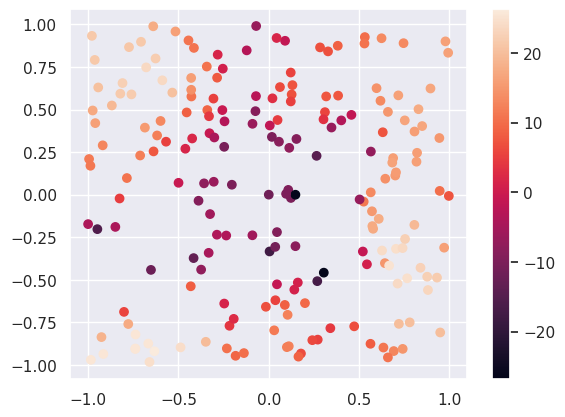

In [5]:
plt.scatter(X[:,0], X[:,1], c= DRC.ks)
plt.colorbar()

The degree of shading here is highly suggestive that edge effects are determining the behavior. Let's try with a lower $t$.

The negative curvature may indicate that adding edges in the center causes mass to dissipate to the fringes.

# Times below a size-dependent threshold produce NaNs

For a 200-point plane, for any time prior to t=15, `differential_diffusion_curvature_of_edge` spits out NaNs. For a 300 point plane, that threshold is 22. Points all over the plane smash into the same threshold. Is this the time needed to diffuse all the way over the graph, becoming fully connected?

Another indication that the NaNs result from some disconnection in the graph: when adding an $\epsilon$ to each edge, the $t$ threshold diminished, and eventually disappears.


In [170]:
X = plane(200)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
# G = get_adaptive_graph(X, k=10)
A = jnp.array(G.W.todense(), dtype=jnp.float32,)
A = A.at[A < 1e-5].set(0)
# A = A + jnp.ones_like(A)*1e-9
DRC = DiffusionRicciCurvature(allow_self_loops=True)
R = DRC.fit_transform(A, 8)

Using stable entropy


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

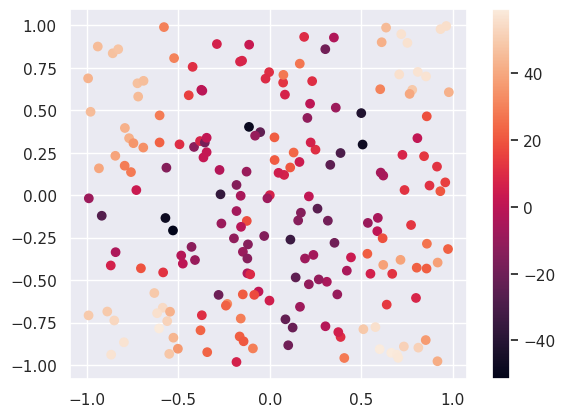

In [21]:
plt.scatter(X[:,0], X[:,1], c= DRC.ks)
plt.colorbar()

In [27]:
np.mean(DRC.ks)

Array(13.9474745, dtype=float32)

0.004449388


Text(0, 0.5, 'Diffusion Ricci Curvature')

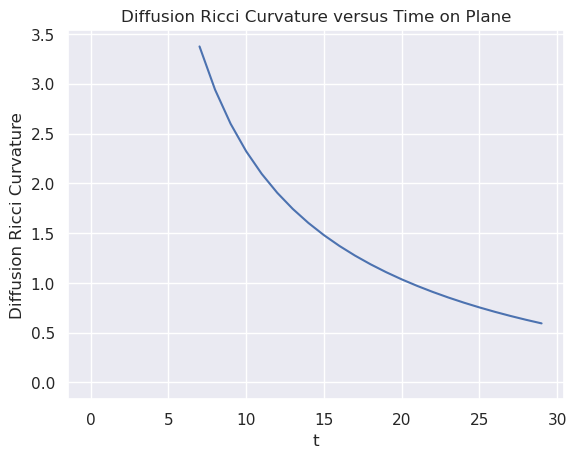

In [26]:
i = 71
js = np.where(A[i]!=0)[0]
j = np.random.choice(js)
print(A[i,j])
values_over_edges = [DRC.differential_diffusion_curvature_of_edge(DRC.A, i,j, t) for t in range(30)]
plt.plot(values_over_edges)
plt.title("Diffusion Ricci Curvature versus Time on Plane")
plt.xlabel("t")
plt.ylabel("Diffusion Ricci Curvature")

In [6]:
A

Array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00477897],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00416667,
        0.00246914],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00416667, ..., 0.        , 0.        ,
        0.        ],
       [0.00477897, 0.        , 0.00246914, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [7]:
jax.scipy.special.entr(A)

Array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        ,  0.02553658],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
         0.022836  ,  0.01482441],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.022836  , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.02553658, -0.        ,  0.01482441, ..., -0.        ,
        -0.        , -0.        ]], dtype=float32)

In [74]:
js

array([], dtype=int64)

Text(0, 0.5, 'Diffusion Ricci Curvature')

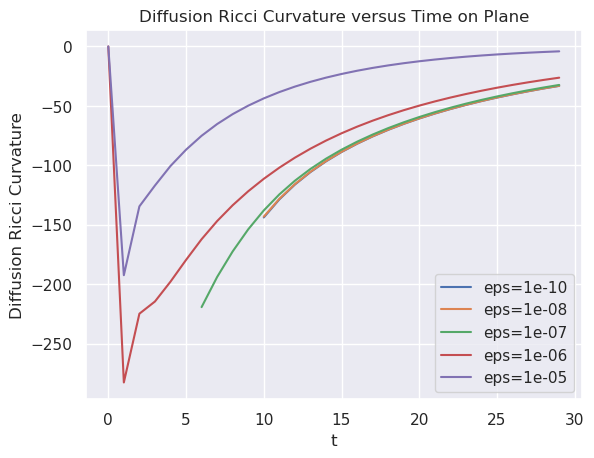

In [12]:
for eps in [1e-10, 1e-8, 1e-7, 1e-6, 1e-5]:
    A_new = A + jnp.ones_like(A)*eps
    values_over_edges = [DRC.differential_diffusion_curvature_of_edge(A_new, 2, 9, t) for t in range(30)]
    plt.plot(values_over_edges, label=f'{eps=}')
plt.title("Diffusion Ricci Curvature versus Time on Plane")
plt.legend()
plt.xlabel("t")
plt.ylabel("Diffusion Ricci Curvature")

In [142]:
A_new

Array([[1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
       [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
       [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
       ...,
       [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
       [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
       [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07]],      dtype=float32)

In [94]:
np.where(DRC.R[16] != DRC.R[16])

(array([  2,   6,   9,  37,  74, 134, 156, 159, 192, 215, 232, 241, 272,
        289, 299]),)

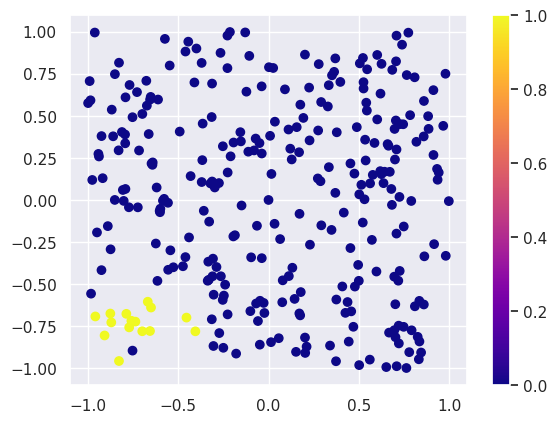

In [89]:
idx = 2
nan_points = np.where(DRC.R[idx]!=DRC.R[idx])
nan_signal = np.zeros(len(X))
nan_signal[nan_points] = 1
plt.scatter(X[:,0], X[:,1], c= nan_signal, cmap='plasma')
plt.colorbar()

### Visual Confimation of diffusion spread

$Pt$ is fully connected *well before* the threshold. Moving from t=8 to t=15 only increases connection across the graph from 1e-4 to 1e-2. **This isn't some gradient issue arising from disconnection.**

In [171]:
from diffusion_curvature.ricci import jax_repeatedly_diffuse_dirac

In [174]:
P = (A / A.sum(axis=1, keepdims=True))
Pt_idx = jax_repeatedly_diffuse_dirac(P, 0, t = 16)

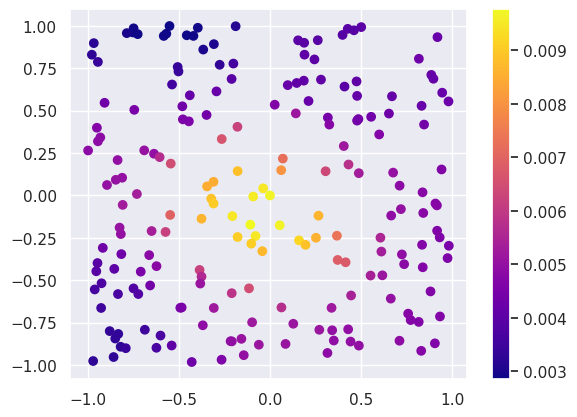

In [175]:
plt.scatter(X[:,0], X[:,1], c= Pt_idx, cmap='plasma')
plt.colorbar()

In [176]:
Pt_idx

Array([0.00970277, 0.00292873, 0.00513955, 0.00421216, 0.00493613,
       0.00617645, 0.00616981, 0.00502012, 0.00470009, 0.00500712,
       0.00458409, 0.00406259, 0.0046988 , 0.00434633, 0.00418156,
       0.00367669, 0.00461223, 0.00459431, 0.00478091, 0.00394143,
       0.00686129, 0.0040571 , 0.00363306, 0.00328441, 0.00330813,
       0.00432834, 0.00440209, 0.00472798, 0.00311309, 0.00375354,
       0.00491448, 0.00532035, 0.00290982, 0.00977126, 0.00327882,
       0.00370593, 0.00500361, 0.00472798, 0.00949625, 0.00515976,
       0.00411758, 0.00348869, 0.00503929, 0.0039922 , 0.00513388,
       0.00532872, 0.00464818, 0.00510189, 0.00302722, 0.00335129,
       0.00619043, 0.00461552, 0.00578727, 0.00402759, 0.00662088,
       0.0049386 , 0.00850475, 0.00388431, 0.00458461, 0.00330364,
       0.0094753 , 0.00434549, 0.00488036, 0.00290579, 0.00922673,
       0.00465649, 0.00442694, 0.00503019, 0.00499261, 0.00320517,
       0.00450065, 0.00440098, 0.00482195, 0.00430764, 0.00464

### Manually Probing Connection Changes

In [45]:
def visualize_edge_change(DRC, A, i, j):
    vals = []
    for eps in np.linspace(-0.05, 0.05, 10):
        vals.append(
            DRC.diffusion_laziness_of_edge_with_surgery(A, i, j, eps)
        )
    plt.plot(vals)
    return vals

In [ ]:
v = visualize_edge_change(DRC, A, )

## How about a plane with lots of points?

In [140]:
X = plane(500)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
A = jnp.array(G.W.todense(), dtype=jnp.float32,)
DRC = DiffusionRicciCurvature(allow_self_loops=True, laziness_method='Dirichlet Energy')
R = DRC.fit_transform(A, 5)

[autoreload of diffusion_curvature.flattening.mioflow failed: Traceback (most recent call last):
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/envs/cuda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/envs/cuda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/envs/cuda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/envs/cuda/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

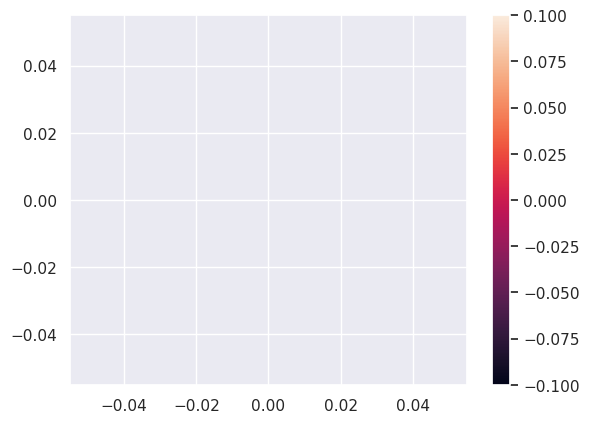

In [ ]:
plt.scatter(X[:,0], X[:,1], c= DRC.ks)
plt.colorbar()

In [59]:
P = (A / A.sum(axis=1, keepdims=True))
Pt_idx = jax_repeatedly_diffuse_dirac(P, 0, t = 10)

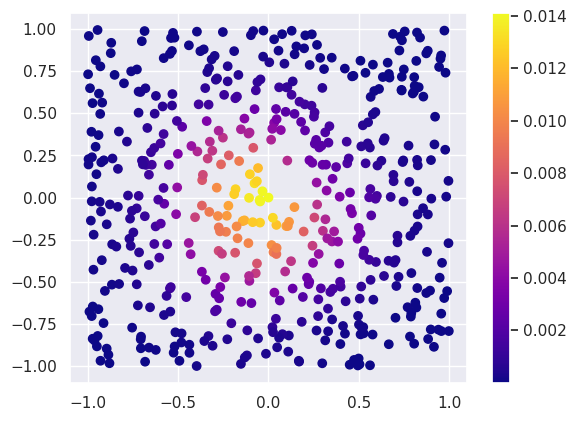

In [60]:
plt.scatter(X[:,0], X[:,1], c= Pt_idx, cmap='plasma')
plt.colorbar()

0.0048076925


Text(0, 0.5, 'Diffusion Ricci Curvature')

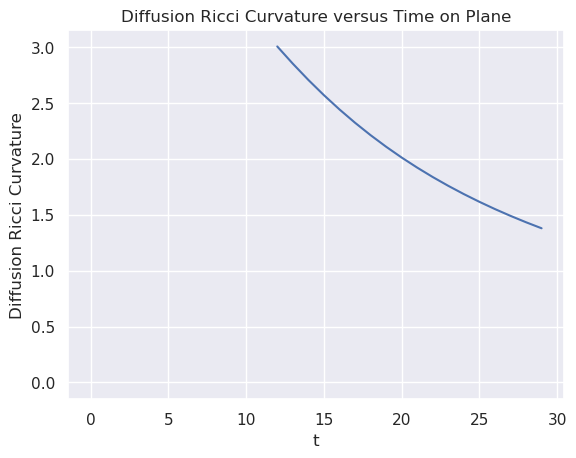

In [61]:
i = 71
js = np.where(A[i]!=0)[0]
j = np.random.choice(js)
print(A[i,j])
values_over_edges = [DRC.differential_diffusion_curvature_of_edge(DRC.A, i,j, t) for t in range(30)]
plt.plot(values_over_edges)
plt.title("Diffusion Ricci Curvature versus Time on Plane")
plt.xlabel("t")
plt.ylabel("Diffusion Ricci Curvature")

In [62]:
Pt_idx

Array([1.41038392e-02, 3.78264603e-03, 7.67193036e-04, 1.83653596e-04,
       3.22879132e-05, 2.53670791e-04, 2.64492887e-03, 6.26498321e-03,
       3.70374793e-04, 5.95795643e-03, 1.79160459e-04, 3.79388184e-05,
       6.43161300e-04, 7.38506642e-05, 1.32171891e-03, 7.78629771e-03,
       1.27379838e-02, 1.25965198e-05, 7.97240180e-04, 1.77748851e-04,
       5.32415649e-03, 4.33549605e-04, 1.42115285e-04, 1.18202051e-05,
       1.15863280e-03, 2.02367385e-03, 3.89502314e-03, 1.01331600e-04,
       4.54128301e-03, 8.84137080e-07, 1.81803433e-03, 2.69513781e-04,
       1.93090842e-03, 7.90694758e-05, 1.38070991e-05, 3.33037402e-04,
       2.34332387e-04, 5.06589968e-05, 7.63692660e-05, 1.16795907e-03,
       1.33735209e-03, 1.53140229e-06, 7.86715009e-06, 2.92244321e-03,
       8.11639521e-03, 1.58702431e-04, 3.57291545e-03, 2.28881789e-03,
       1.31859953e-04, 4.63368255e-04, 4.04383708e-03, 1.11831427e-02,
       9.51537629e-07, 4.48131526e-04, 4.35623724e-06, 2.59992480e-03,
      

In [67]:
jax.scipy.special.entr(Pt_idx)

Array([6.01008050e-02, 2.10970715e-02, 5.50290057e-03, 1.57987257e-03,
       3.33883421e-04, 2.10026046e-03, 1.56979468e-02, 3.17808762e-02,
       2.92632938e-03, 3.05227768e-02, 1.54565822e-03, 3.86199565e-04,
       4.72666649e-03, 7.02575780e-04, 8.76143947e-03, 3.78055088e-02,
       5.55779487e-02, 1.42115066e-04, 5.68779418e-03, 1.53488596e-03,
       2.78746262e-02, 3.35719343e-03, 1.25898118e-03, 1.34108501e-04,
       7.83295371e-03, 1.25525268e-02, 2.16098055e-02, 9.31958086e-04,
       2.44981572e-02, 1.23236805e-05, 1.14717958e-02, 2.21510441e-03,
       1.20677240e-02, 7.46825710e-04, 1.54505964e-04, 2.66671553e-03,
       1.95873063e-03, 5.01037401e-04, 7.23975303e-04, 7.88664073e-03,
       8.84934328e-03, 2.05044453e-05, 9.24611522e-05, 1.70534365e-02,
       3.90712619e-02, 1.38840498e-03, 2.01311391e-02, 1.39153721e-02,
       1.17800653e-03, 3.55727272e-03, 2.22838130e-02, 5.02497479e-02,
       1.31932466e-05, 3.45528405e-03, 5.37729647e-05, 1.54754622e-02,
      

## Using the Dirichlet Energy

In [185]:
from diffusion_curvature.ricci import dirichlet_energy

  0%|          | 0/200 [00:00<?, ?it/s]

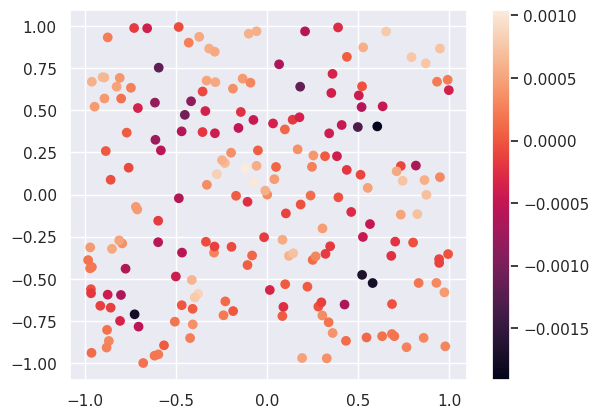

In [186]:
X = plane(200)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
A = jnp.array(G.W.todense(), dtype=jnp.float32,)
DRC = DiffusionRicciCurvature(allow_self_loops=True, laziness_method='Dirichlet Energy')
R = DRC.fit_transform(A, 5)
plt.scatter(X[:,0], X[:,1], c= DRC.ks)
plt.colorbar()

0.0044444446


Text(0, 0.5, 'Diffusion Ricci Curvature')

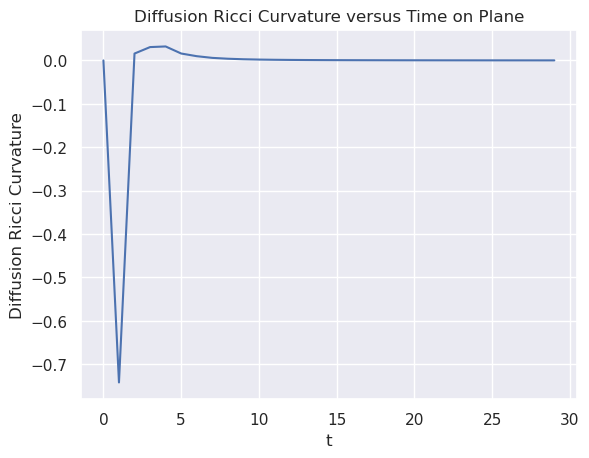

In [146]:
i = 71
js = np.where(A[i]!=0)[0]
j = np.random.choice(js)
print(A[i,j])
values_over_edges = [DRC.differential_diffusion_curvature_of_edge(DRC.A, i,j, t) for t in range(30)]
plt.plot(values_over_edges)
plt.title("Diffusion Ricci Curvature versus Time on Plane")
plt.xlabel("t")
plt.ylabel("Diffusion Ricci Curvature")

  0%|          | 0/200 [00:00<?, ?it/s]

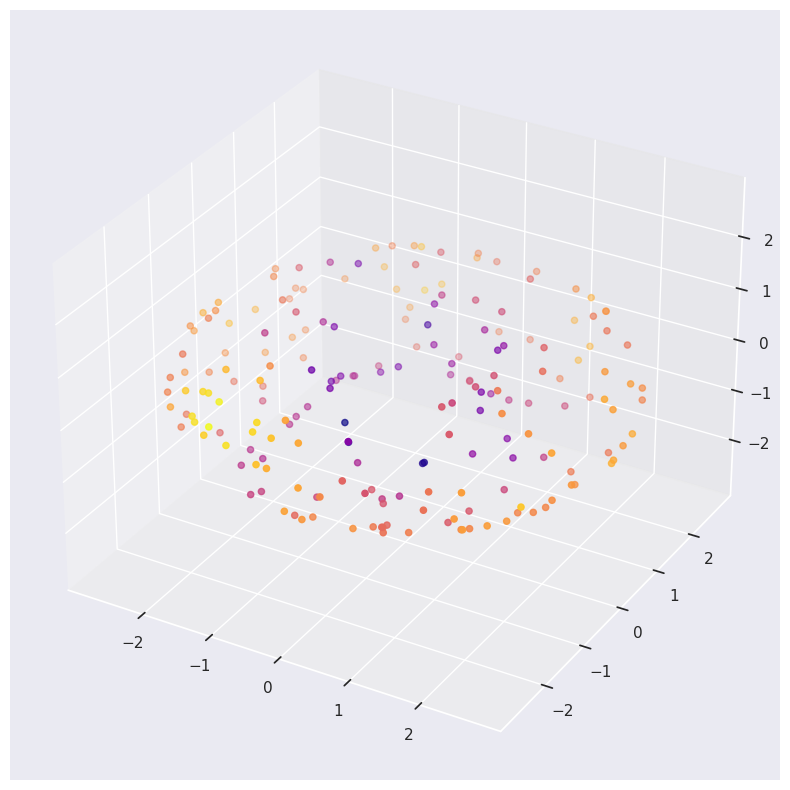

In [195]:
X,ks = torus(200)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
A = jnp.array(G.W.todense(), dtype=jnp.float32,)
DRC = DiffusionRicciCurvature(allow_self_loops=True, laziness_method='Dirichlet Energy')
R = DRC.fit_transform(A, 25)
plot_3d(X, DRC.ks)

In [199]:
plot_3d(X, DRC.ks, use_plotly=True)

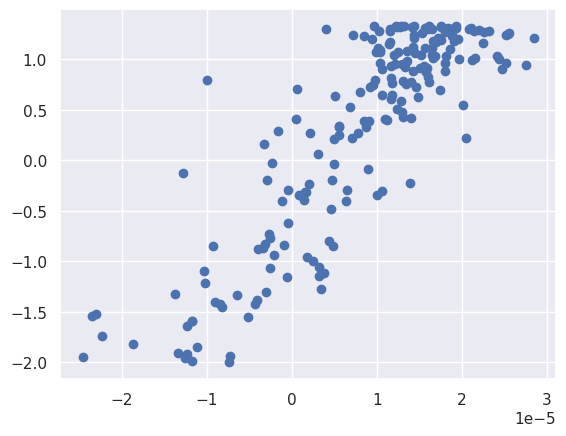

In [200]:
plt.scatter(DRC.ks, ks)

In [201]:
import scipy.stats
scipy.stats.pearsonr(DRC.ks, ks)

PearsonRResult(statistic=0.8652075459573735, pvalue=2.8450779671650698e-61)

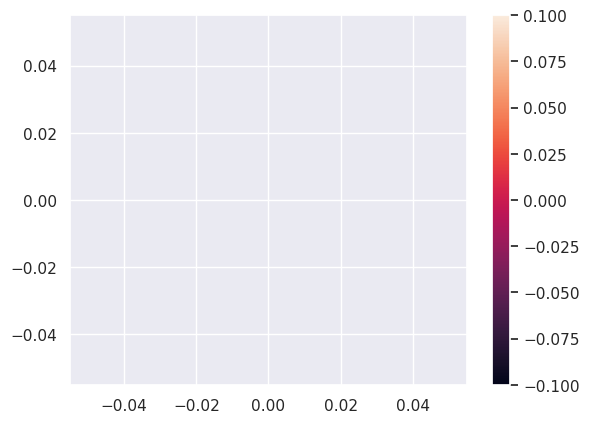

In [ ]:
plt.scatter(X[:,0], X[:,1], c= DRC.ks)
plt.colorbar()

In [129]:
P = (A / A.sum(axis=1, keepdims=True))
Pt = jnp.linalg.matrix_power(P,25)

In [130]:
dirichlet_energy

<function diffusion_curvature.ricci.dirichlet_energy(A, F)>

In [131]:
d_energies = dirichlet_energy(A,Pt)

In [132]:
d_energies

Array([6.2194034e-05, 5.6060155e-05, 5.9673985e-05, ..., 4.6845147e-05,
       4.8179365e-05, 5.1522762e-05], dtype=float32)

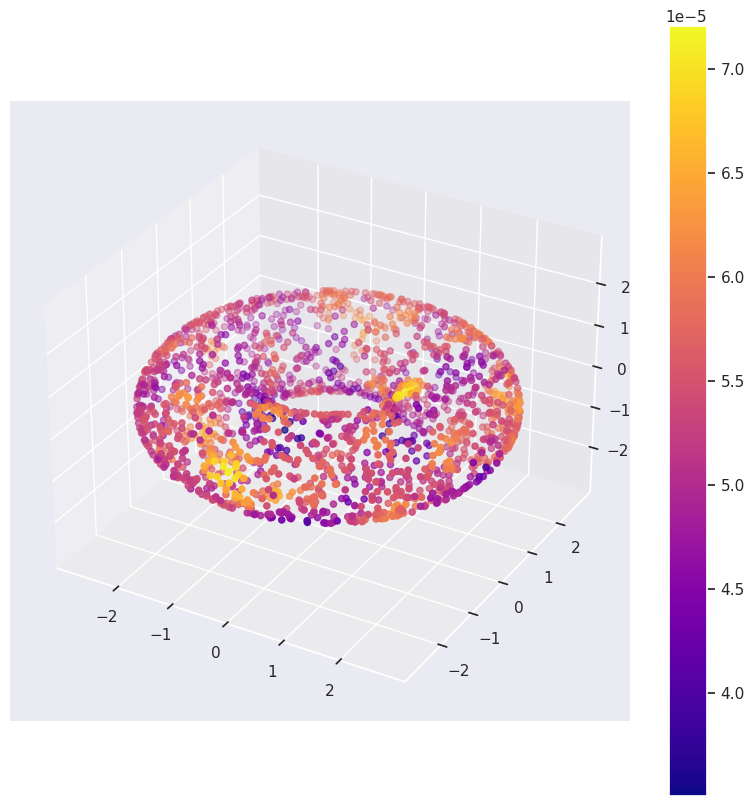

In [133]:
plot_3d(X, d_energies, colorbar=True)

In [105]:
Dnoh = jnp.diag(1/A.sum(axis=1, keepdims=False))
L = jnp.eye(len(A)) - (Dnoh @ A @ Dnoh)
trace = lambda f: jnp.trace(f[:,None].T @ L @ f[:,None])

In [106]:
jax.vmap(trace)(Pt)

Array([-0.05814677, -0.06606423, -0.0765627 , ..., -0.0544759 ,
       -0.06903544, -0.05689031], dtype=float32)

# Conclusion